In [4]:
import pandas as pd
from rpy2.robjects import r
import rpy2.robjects.pandas2ri as pandas2ri
pandas2ri.activate() #MANDATORY !
#load into the env
file="~/govWebsites/rfiles/d.Rdata"
rf=r['load'](file)

In [5]:
d = r['d']

In [6]:
d['doc']

1         mayor shepherd city clerk  board member also ...
2         present  dale grant craft mayor shepherd  att...
3         mayor shepherd city clerk  board members amp ...
4         present  dale grant craft mayor shepherd  att...
5        notice   pm   city council room present  mayor...
6         mayor shepherd city clerk  board member also ...
7         present  dale grant craft mayor shepherd  att...
8         present  grant craft made  motion  approve  m...
9         mayor shepherd city clerk  board member also ...
10       notice   pm   city council room present  mayor...
11       pm  present  grant craft made  motion  approve...
12       notice   pm   city council room present  mayor...
13       notice   pm   city council room present  mayor...
14        present  grant craft made  motion  approve  m...
15       present  board members  huckleberry city clerk...
16       pm  present  grant mayor shepherd  made  motio...
17       opened  public hearing   proposed cumulative c.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(d['doc'])
X_train_counts.shape

(16116, 35135)

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(16116, 35135)

Naive Bayes

In [9]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, d['winner'])

In [10]:
docs_new = ['God is love', 'OpenGL on the GPU is fast', 'we like spending lots of money on social issues', 'waste management', 'climate change']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

In [11]:
predicted

array(['Republican', 'Republican', 'Democratic', 'Democratic', 'Democratic'],
      dtype='<U10')

In [14]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),
 ])

In [15]:
text_clf.fit(d['doc'], d['winner'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [16]:
from sklearn.model_selection import train_test_split

In [56]:
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(d['winner'])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(d['doc'], y, test_size=0.33, random_state=42)

In [18]:
text_clf.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [19]:
import numpy as np
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)        

0.75202105658958451

SVM:

In [58]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=0.001, random_state=42)),
])
text_clf.fit(X_train, y_train)

/usr/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [80]:
predicted = text_clf.predict(X_test)
sum(predicted == y_test)

array([3419, 1900, 1900, ..., 3419, 3419, 3419])

performance analysis

In [81]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted, target_names=['Democrat','Republican']))

             precision    recall  f1-score   support

   Democrat       0.77      0.98      0.86      3419
 Republican       0.91      0.48      0.63      1900

avg / total       0.82      0.80      0.78      5319



In [30]:
metrics.confusion_matrix(y_test, predicted)

array([[3334,   85],
       [ 994,  906]])

In [62]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted)

In [77]:
thresholds

array([2, 1, 0])

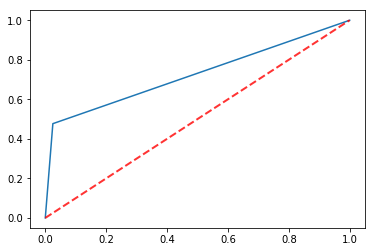

In [70]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.show()

Grid search parameters

In [22]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

In [23]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [41]:
gs_clf = gs_clf.fit(X_train, y_train)

In [42]:
gs_clf.best_score_

0.79188663517643787

In [43]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


In [55]:
lb = preprocessing.LabelBinarizer()
a = lb.fit_transform(y_train)
y_train

6051     Democratic
9498     Republican
38       Republican
979      Democratic
11028    Democratic
5489     Democratic
11542    Democratic
1135     Republican
19913    Democratic
13088    Democratic
8960     Republican
6787     Democratic
15636    Republican
3558     Republican
6485     Democratic
7498     Democratic
5965     Democratic
12870    Democratic
10866    Democratic
6669     Democratic
1321     Republican
6486     Democratic
16288    Republican
969      Democratic
14947    Democratic
7922     Republican
3465     Republican
14423    Democratic
8263     Republican
5682     Democratic
            ...    
6650     Democratic
6994     Democratic
3663     Republican
9323     Republican
20549    Republican
17528    Republican
13317    Democratic
1203     Republican
20404    Democratic
2875     Republican
10978    Democratic
20917    Democratic
13851    Democratic
14105    Democratic
14404    Democratic
18271    Democratic
7600     Democratic
5971     Democratic
17196    Republican
